# Welcome to the GEP Generator

This jupyter based interface has been designed to support scenario runs for the Global Electrification Platform. 

The interface is built upon a modified version of [OnSSET](http://www.onsset.org/) developed by KTH dESA to provide an easy and quick way to generate electrification investment scenarios compatible with GEP data guidelines and protocols. 

Follow the steps below to generate custom electrification investment outlooks for your country of interest.

#### Start by importing the code 

In [1]:
from gep_onsset import *
from IPython.display import display, Markdown, HTML
%matplotlib inline

2019-06-26 15:31:57,991		CACHEDIR=C:\Users\asahl\.matplotlib
2019-06-26 15:31:58,017		Using fontManager instance from C:\Users\asahl\.matplotlib\fontlist-v300.json
2019-06-26 15:31:58,724		Loaded backend module://ipykernel.pylab.backend_inline version unknown.
2019-06-26 15:31:58,728		Loaded backend module://ipykernel.pylab.backend_inline version unknown.
2019-06-26 15:31:58,741		Loaded backend module://ipykernel.pylab.backend_inline version unknown.


# 1. GIS data selection

First, run the cell below to browse to the directory your input CSV file is located at and select the input file. Sample file shall be located at .\ gep-onsset\test_data. 


In [2]:
import tkinter as tk
from tkinter import filedialog, messagebox
from openpyxl import load_workbook
root = tk.Tk()
root.withdraw()
root.attributes("-topmost", True)
messagebox.showinfo('OnSSET', 'Open the input file with extracted GIS data')
input_file = filedialog.askopenfilename()

onsseter = SettlementProcessor(input_file)
onsseter.df['IsUrban'] = 0
onsseter.df['Conflict'] = 0
onsseter.df['PerCapitaDemand'] = 0

# 2. Modelling period and target electrification rate

Next, define the modelling period and the electrification rate to be achieved by the end of the analysis. Further down you will also define an intermediate year and target (in the ***Levers*** section).

In [3]:
start_year = 2018
end_year = 2030
electrification_rate_target = 1 # E.g. 1 for 100% electrification rate or 0.80 for 80% electrification rate 

# 3. Levers

Next, define the values of the levers. These are the 6 levers that are available on the GEP Explorer. Contrary to the GEP Explorer where each lever has two or three pre-defined values, here they can take any value.

#### Lever 1: Population growth

For the first lever first, enter the expected population in the country by the end year of the analysis (e.g. 2030). The default values in the GEP Explorer are based on the medium growth variant and high growth variant of the UN Population Database, found <a href="https://population.un.org/wpp/" target="_blank">here</a>.

In [4]:
end_year_pop = 26858618

#### Lever 2: Electricity demand target
For the second lever, enter the target tier (level of electricity access) for urban and rural households respectively. This can take a value between **1** (lowest level of electricity access) and **5** (highest level of electricity access) as in ESMAPs Multi-Tier Framework for Measuring Electricity Access (found <a href="https://www.esmap.org/node/55526" target="_blank">here</a>). Alternatively, enter **6** to use a distribution of the tiers across the country based on poverty levels and GDP according to the methodology found here *link*.   

In [5]:
urban_target_tier = 5
rural_target_tier = 3

#### Lever 3: Intermediate electrification rate target
For the third lever, enter the intermediate target year and target electrification rate for that year.

In [6]:
intermediate_year = 2025
intermediate_electrification_target = 0.63 # E.g. for a target electrification rate of 75%, enter 0.75

#### Lever 4: Grid generating cost of electricity
This lever examines different average costs of generating electricity by the power-plants connected to the national grid. This cost is one of the factors that affect the LCoE of connecting to the grid (together with extension of the grid lines etc.), and may affect the split between grid- and off-grid technologies.

In [7]:
grid_generation_cost = 0.046622           ### This is the grid cost electricity USD/kWh as expected in the end year of the analysis

#### Lever 5: PV system cost adjustment
This lever reflects the role of PV system costs on electrification results. All PV based systems will be adjusted by a factor to simulate a higher or lower cost of PV systems (compared to the baseline values entered below). A value lower than 1 means lower investment costs for PV systems compared to baseline, and a value larger than 1 means higher investment cost for PV systems compared to baseline. E.g. ***0.75*** would mean a cost that is 25% lower compared to baseline costs.

In [8]:
pv_adjustment_factor = 1

#### Lever 6: Prioritization algorithm
This lever reflects the prioritization approach in order to achieve the electrification rate specified (in Lever 3) in intermediate target year of the analysis. There are currently two options available:

**Baseline**: Prioritizes grid densification first (ramp up in already electrified clusters) then selection based on lowest invetsment cost per capita. Grid densification is limited by a grid capacity cap per year and a number of sensible grid connections per year.

**Intensification**: Same as above, plus automatic grid intensification to all clusters within a predefined buffer of X km. (Default value for X is 2km)

In [9]:
prioritization = 1                        # Select 1 or 2. 1 = baseline, 2 = intensification, 3 = easily accessible settlements

auto_intensification = 2                  # Buffer distance (km) for automatic intensification if choosing prioritization 1
annual_new_grid_connections_limit = 109 # This is the maximum amount of new households that can be connected to the grid in one year (thousands)
annual_grid_cap_gen_limit = 100       # This is the maximum generation capacity that can be added to the grid in one year (MW)

# 4. Enter country specific data

In addition to the levers above the user can customize a large number of variables describing the social - economic - technological environment in the selected country. 

**Note!** Most input values shall represent future estimates for the variable, i.e. they describe and **NOT** current values.

### a. Demographics and Social components

In [10]:
pop_start_year = 18620000       ### Write the population in the base year (e.g. 2018) 

urban_ratio_start_year = 0.17   ### Write the urban population population ratio in the base year (e.g. 2018)
urban_ratio_end_year = 0.20     ### Write the urban population population ratio in the end year (e.g. 2030)

num_people_per_hh_urban = 4.3     ### Write the number of people per household expected in the end year (e.g. 2030)
num_people_per_hh_rural = 4.5   ### Write the number of people per household expected in the end year (e.g. 2030)

elec_ratio_start_year = 0.11   ### Write the electrification rate in the base year (e.g. 2018)
urban_elec_ratio = 0.492       ### Write urban electrification rate in the base year (e.g. 2018)
rural_elec_ratio = 0.032         ### Write rural electrification rate in the base year (e.g. 2018)

### b. Technology specifications & costs

The cell below contains all the information that is used to calculate the levelized costs for all the technologies, including grid. These default values should be updated to reflect the most accurate values in the country. There are currently 7 potential technologies to include in the model:
* Grid
* PV Mini-grid
* Wind Mini-grid
* Hydro Mini-grid
* Diesel Mini-grid
* PV Stand-alone systems
* Diesel Stand-alone systems

First, decide whether to include diesel technologies or not:

In [11]:
diesel_techs = 0                      ### 0 = diesel NOT included, 1 = diesel included 

In [12]:
grid_power_plants_capital_cost = 2000 ### The cost in USD/kW to for capacity upgrades of the grid
grid_losses = 0.1                     ### The fraction of electricity lost in transmission and distribution (percentage) 
base_to_peak = 0.8                    ### The ratio of base grid demand to peak demand (percentage) 
existing_grid_cost_ratio = 0.1        ### The additional cost per round of electrification (percentage) 

In [13]:
diesel_price = 0.5                   ### This is the diesel price in USD/liter as expected in the end year of the analysis.

In [14]:
sa_diesel_capital_cost = 938          ### Stand-alone Diesel capital cost (USD/kW) as expected in the years of the analysis
mg_diesel_capital_cost = 721          ### Mini-grid Diesel capital cost (USD/kW) as expected in the years of the analysis
mg_pv_capital_cost = 2950             ### Mini-grid PV capital cost (USD/kW) as expected in the years of the analysis
mg_wind_capital_cost = 3750           ### Mini-grid Wind capital cost (USD/kW) as expected in the years of the analysis
mg_hydro_capital_cost = 3000          ### Mini-grid Hydro capital cost (USD/kW) as expected in the years of the analysis

In [15]:
sa_pv_capital_cost_1 = 9620          ### Stand-alone PV capital cost (USD/kW) for household systems under 20 W
sa_pv_capital_cost_2 = 8780          ### Stand-alone PV capital cost (USD/kW) for household systems between 21-50 W
sa_pv_capital_cost_3 = 6380           ### Stand-alone PV capital cost (USD/kW) for household systems between 51-100 W
sa_pv_capital_cost_4 = 4470           ### Stand-alone PV capital cost (USD/kW) for household systems between 101-1000 W
sa_pv_capital_cost_5 = 6950           ### Stand-alone PV capital cost (USD/kW) for household systems over 1 kW

The cells below contain additional technology specifications

In [16]:
coordinate_units = 1000  # 1000 if coordinates are in m, 1 if coordinates are in km
discount_rate = 0.08 # E.g. 0.08 means a discount rate of 8%

# Transmission and distribution costs
hv_line_capacity=69 # kV
hv_line_cost=53000 # USD/km
mv_line_cost = 7000 # USD/kW
mv_line_capacity=50 # kV
mv_line_max_length=50 # km
mv_increase_rate=0.1
max_mv_line_dist = 50 # km
MV_line_amperage_limit = 8  # Ampere (A)
lv_line_capacity=0.24 #kV
lv_line_max_length=0.8 # km
lv_line_cost=4250 # USD/km
service_Transf_type=50  # kVa
service_Transf_cost=4250  # $/unit
max_nodes_per_serv_trans=300  # maximum number of nodes served by each service transformer
hv_lv_transformer_cost=25000 # USD/unit
hv_mv_transformer_cost=25000 # USD/unit
mv_lv_transformer_cost=10000 # USD/unit
mv_mv_transformer_cost=10000 # USD/unit


# Centralized grid costs
grid_calc = Technology(om_of_td_lines=0.1,
                        distribution_losses=grid_losses,
                        connection_cost_per_hh=150,
                        base_to_peak_load_ratio=base_to_peak,
                        capacity_factor=1,
                        tech_life=30,
                        grid_capacity_investment=grid_power_plants_capital_cost,
                        grid_price=grid_generation_cost)

# Mini-grid hydro costs
mg_hydro_calc = Technology(om_of_td_lines=0.03,
                            distribution_losses=0.05,
                            connection_cost_per_hh=100,
                            base_to_peak_load_ratio=0.85,
                            capacity_factor=0.5,
                            tech_life=30,
                            capital_cost=mg_hydro_capital_cost,
                            om_costs=0.02,
                            )

# Mini-grid wind costs
mg_wind_calc = Technology(om_of_td_lines=0.03,
                            distribution_losses=0.05,
                            connection_cost_per_hh=100,
                            base_to_peak_load_ratio=0.85,
                            capital_cost=mg_wind_capital_cost,
                            om_costs=0.02,
                            tech_life=20,
                            )

# Mini-grid PV costs
mg_pv_calc = Technology(om_of_td_lines=0.03,
                        distribution_losses=0.05,
                        connection_cost_per_hh=100,
                        base_to_peak_load_ratio=0.85,
                        tech_life=20,
                        om_costs=0.02,
                        capital_cost=mg_pv_capital_cost * pv_adjustment_factor                        
                       )

# Stand-alone PV costs
sa_pv_calc = Technology(base_to_peak_load_ratio=0.9,
                        tech_life=15,
                        om_costs=0.02,
                        capital_cost={0.020: sa_pv_capital_cost_1 * pv_adjustment_factor, 
                                      0.050: sa_pv_capital_cost_2 * pv_adjustment_factor, 
                                      0.100: sa_pv_capital_cost_3 * pv_adjustment_factor, 
                                      1: sa_pv_capital_cost_4 * pv_adjustment_factor, 
                                      5: sa_pv_capital_cost_5 * pv_adjustment_factor},
                        standalone=True
                        )

# Mini-grid diesel costs
mg_diesel_calc = Technology(om_of_td_lines=0.03,
                            distribution_losses=0.05,
                            connection_cost_per_hh=100,
                            base_to_peak_load_ratio=0.85,
                            capacity_factor=0.7,
                            tech_life=15,
                            om_costs=0.1,
                            efficiency=0.33,
                            capital_cost=mg_diesel_capital_cost,
                            diesel_price=diesel_price,
                            diesel_truck_consumption=33.7,
                            diesel_truck_volume=15000,
                            )

# Stand-alone diesel costs
sa_diesel_calc = Technology(base_to_peak_load_ratio=0.9,
                            capacity_factor=0.7,
                            tech_life=10,
                            om_costs=0.1,
                            capital_cost=sa_diesel_capital_cost,
                            diesel_price=diesel_price,
                            standalone=True,
                            efficiency=0.28,
                            diesel_truck_consumption=14,
                            diesel_truck_volume=300)

# 5. GIS data import and processing

OnSSET is a GIS based tool and its proper function depends heavily on the diligent preparation and calibration of the necessary geospatial data. Documentation on GIS processing in regards to OnSSET can be found <a href="http://onsset-manual.readthedocs.io/en/latest/data_acquisition.html" target="_blank">here</a>. The following cell reads the CSV-file containing the extracted GIS data for the country chosen in the previous section, and displays a snap-shot of some of the data.

In [17]:
yearsofanalysis = [intermediate_year, end_year]

onsseter.condition_df()
onsseter.grid_penalties()
onsseter.calc_wind_cfs()
onsseter.calibrate_pop_and_urban(pop_start_year, end_year_pop, end_year_pop, urban_ratio_start_year, 
                                 urban_ratio_end_year, start_year, end_year, intermediate_year)

eleclimits = {intermediate_year: intermediate_electrification_target, end_year: electrification_rate_target}
time_steps = {intermediate_year: intermediate_year-start_year, end_year: end_year-intermediate_year}

display(Markdown('#### The csv file has been imported correctly. Here is a preview:'))
display(onsseter.df[['Country','Pop','NightLights','TravelHours','GHI','WindVel','Hydropower','HydropowerDist']].sample(7))


2019-06-26 15:32:15,326		Ensure that columns that are supposed to be numeric are numeric
2019-06-26 15:32:15,380		Adding column "ElectrificationOrder"
2019-06-26 15:32:15,383		Replace null values with zero
2019-06-26 15:32:15,440		Sort by country, Y and X
2019-06-26 15:32:15,719		Classify road dist
2019-06-26 15:32:20,229		Classify substation dist
2019-06-26 15:32:24,838		Classify land cover
2019-06-26 15:32:29,414		Classify elevation
2019-06-26 15:32:33,974		Classify slope
2019-06-26 15:32:38,556		Combined classification
2019-06-26 15:32:38,620		Grid penalty
2019-06-26 15:32:43,410		Calculate Wind CF
2019-06-26 15:32:57,995		Calibrate current population
2019-06-26 15:33:02,887		Project future population


#### The csv file has been imported correctly. Here is a preview:

,Country,Pop,NightLights,TravelHours,GHI,WindVel,Hydropower,HydropowerDist
131905,Malawi,0.03240,0.0,2.61667,1974,4.36663,267,23.54788
51365,Malawi,4.06470,0.0,2.43333,2105,5.18151,270,16.76174
151536,Malawi,3.85193,0.0,0.10000,1933,4.01984,3128,30.84330
58334,Malawi,9.92175,0.0,1.93333,2096,4.52886,265,9.35295
29353,Malawi,29.41408,0.0,1.58333,2089,5.13260,154,10.49102
168136,Malawi,5.31444,0.0,0.28333,1929,4.40706,1055,27.98396
192641,Malawi,9.58758,0.0,0.96667,2026,4.13480,150,9.45601


#### Calibration of currently electrified settlements

The model calibrates which settlements are likely to be electrified in the start year, to match the national statistical values defined above. A settlement is considered to be electrified if it meets all of the following conditions:
- Has more night-time lights than the defined threshold (this is set to 0 by default)
- Is closer to the existing grid network than the distance limit
- Has more population than the threshold

First, define the threshold limits. Then run the calibration and check if the results seem okay. Else, redefine these thresholds and run again.

In [18]:
min_night_lights = 0    ### 0 Indicates no night light, while any number above refers to the night-lights intensity
min_pop = 0      ### Settlement population above which we can assume that it could be electrified

max_service_transformer_distance = 2    ### Distance  in km from the existing grid network below which we can assume a settlement could be electrified
max_mv_line_distance = 2
max_hv_line_distance = 25

Technology.set_default_values(base_year=start_year, start_year=start_year, end_year=end_year, discount_rate=discount_rate,
                             HV_line_type=hv_line_capacity, HV_line_cost=hv_line_cost, MV_line_type=mv_line_capacity,
                             MV_line_amperage_limit=MV_line_amperage_limit, MV_line_cost=mv_line_cost, LV_line_type=lv_line_capacity,
                             LV_line_cost=lv_line_cost, LV_line_max_length=lv_line_max_length, 
                             service_Transf_type=service_Transf_type, service_Transf_cost = service_Transf_cost,
                             max_nodes_per_serv_trans=max_nodes_per_serv_trans, MV_LV_sub_station_cost=mv_lv_transformer_cost,
                             MV_MV_sub_station_cost=mv_mv_transformer_cost, HV_LV_sub_station_cost=hv_lv_transformer_cost,
                             HV_MV_sub_station_cost=hv_mv_transformer_cost)

elec_modelled, urban_internal_elec_ratio, rural_internal_elec_ratio = onsseter.elec_current_and_future(elec_ratio_start_year, 
                                                                                                       urban_elec_ratio, 
                                                                                                       rural_elec_ratio, 
                                                                                                       pop_start_year, 
                                                                                                       start_year,
                                                                                                       min_night_lights=min_night_lights, 
                                                                                                       min_pop=min_pop, 
                                                                                                       max_transformer_dist=max_service_transformer_distance, 
                                                                                                       max_mv_dist=max_mv_line_distance, 
                                                                                                       max_hv_dist=max_hv_line_distance) 

onsseter.grid_reach_estimate(start_year, gridspeed=9999)

2019-06-26 15:33:41,176		Calibrate current electrification


We have identified the existence of transformers or MV lines as input data; therefore we proceed using those for the calibration
The modelled electrification rate achieved is 0.11.Urban elec. rate is 0.51 and Rural elec. rate is 0.03. 
If this is not acceptable please revise this part of the algorithm


The figure below show the results of the calibration. Settlements in **blue** are considered to be (at least partly) electrified already in the start year of the analysis, while settlements in **yellow** are yet to be electrified. Re-running the calibration step with different intial values may change the map below.

<Figure size 2160x2160 with 0 Axes>

2019-06-26 15:34:15,733		update_title_pos
2019-06-26 15:34:15,774		findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('C:\\Users\\asahl\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf') with score of 0.050000.
2019-06-26 15:34:15,938		update_title_pos
2019-06-26 15:34:16,067		update_title_pos
2019-06-26 15:34:16,139		update_title_pos
2019-06-26 15:34:16,185		update_title_pos


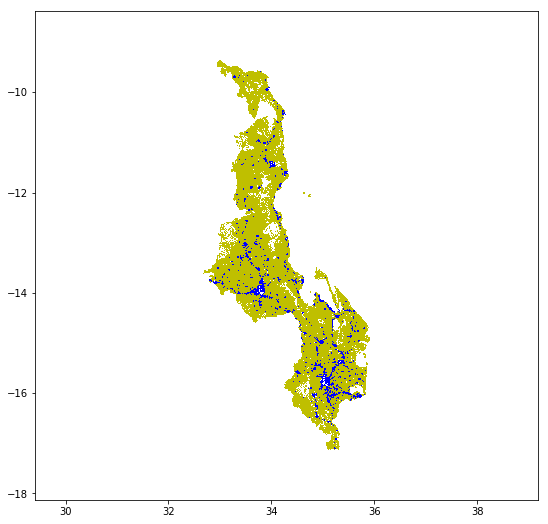

<Figure size 2160x2160 with 0 Axes>

In [19]:
from matplotlib import pyplot as plt
colors = ['#73B2FF','#EDD100','#EDA800','#1F6600','#98E600','#70A800','#1FA800']
plt.figure(figsize=(9,9))
plt.plot(onsseter.df.loc[onsseter.df[SET_ELEC_CURRENT]==0, SET_X_DEG], onsseter.df.loc[onsseter.df[SET_ELEC_CURRENT]==0, SET_Y_DEG], 'y,')
plt.plot(onsseter.df.loc[onsseter.df[SET_ELEC_CURRENT]==1, SET_X_DEG], onsseter.df.loc[onsseter.df[SET_ELEC_CURRENT]==1, SET_Y_DEG], 'b,')
if onsseter.df[SET_X_DEG].max() - onsseter.df[SET_X_DEG].min() > onsseter.df[SET_Y_DEG].max() - onsseter.df[SET_Y_DEG].min():
    plt.xlim(onsseter.df[SET_X_DEG].min() - 1, onsseter.df[SET_X_DEG].max() + 1)
    plt.ylim((onsseter.df[SET_Y_DEG].min()+onsseter.df[SET_Y_DEG].max())/2 - 0.5*abs(onsseter.df[SET_X_DEG].max() - onsseter.df[SET_X_DEG].min()) - 1, (onsseter.df[SET_Y_DEG].min()+onsseter.df[SET_Y_DEG].max())/2 + 0.5*abs(onsseter.df[SET_X_DEG].max() - onsseter.df[SET_X_DEG].min()) + 1)
else:
    plt.xlim((onsseter.df[SET_X_DEG].min()+onsseter.df[SET_X_DEG].max())/2 - 0.5*abs(onsseter.df[SET_Y_DEG].max() - onsseter.df[SET_Y_DEG].min()) - 1, (onsseter.df[SET_X_DEG].min()+onsseter.df[SET_X_DEG].max())/2 + 0.5*abs(onsseter.df[SET_Y_DEG].max() - onsseter.df[SET_Y_DEG].min()) + 1)
    plt.ylim(onsseter.df[SET_Y_DEG].min() -1, onsseter.df[SET_Y_DEG].max() +1)
plt.figure(figsize=(30,30))

In some cases it can be of interest to filter out clusters with very low populations, e.g. to increase computational speed or to remove false positives in the data. Setting the **pop_threshold** variable below larger than 0 will filter out all settlements below that threshold form the analysis.

In [20]:
pop_threshold = 0  # If you wish to remove low density population cells, enter a threshold above 0
onsseter.df = onsseter.df.loc[onsseter.df[SET_POP] > pop_threshold]

# 6. Define the demand

This piece of code defines the target electricity demand in the region/country. Residential electricity demand is defined as kWh/household/year, while all other demands are defined as kWh/capita/year. Note that at the moment, all productive uses demands are set to 0 by default.

In [21]:
# Define the annual household electricity targets to choose from
tier_1 = 38.7  # 38.7 refers to kWh/household/year. 
tier_2 = 219
tier_3 = 803
tier_4 = 2117
tier_5 = 2993

onsseter.prepare_wtf_tier_columns(num_people_per_hh_rural, num_people_per_hh_urban, tier_1, tier_2, tier_3, tier_4, tier_5)

2019-06-26 15:34:16,554		Populate ResidentialDemandTier columns


In [22]:
onsseter.df[SET_EDU_DEMAND] = 0           # Demand for educational facilities (kWh/capita/year)
onsseter.df[SET_HEALTH_DEMAND] = 0        # Demand for health facilities (kWh/capita/year)
onsseter.df[SET_COMMERCIAL_DEMAND] = 0    # Demand for commercial activities (kWh/capita/year)
onsseter.df[SET_AGRI_DEMAND] = 0          # Demand for agricultural activities (kWh/capita/year)
productive_demand = 0 # 1 if productive demand is defined and should be included, else 0

# 7. Start a scenario run, which calculate and compare technology costs for every settlement in the country

Based on the previous calculation this piece of code identifies the LCoE that every off-grid technology can provide, for each single populated settlement of the selected country. The cell then takes all the currently grid-connected points in the country, and looks at the points within a certain distance from them, to see if it is more economical to connect them to the grid, or to use one of the off-grid technologies calculated above. Once more points are connected to the grid, the process is repeated, so that new points close to those points might also be connected. This is repeated until there are no new points to connect to the grid.

In [23]:
onsseter.current_mv_line_dist()

for year in yearsofanalysis:
    end_year_pop = 1
        
    eleclimit = eleclimits[year]
    time_step = time_steps[year]
    grid_cap_gen_limit = time_step * annual_grid_cap_gen_limit * 1000
    grid_connect_limit = time_step * annual_new_grid_connections_limit * 1000
    
    onsseter.set_scenario_variables(year, num_people_per_hh_rural, num_people_per_hh_urban, time_step,
                                            start_year, urban_elec_ratio, rural_elec_ratio, urban_target_tier, 
                                            rural_target_tier, end_year_pop, productive_demand)

    onsseter.calculate_off_grid_lcoes(mg_hydro_calc, mg_wind_calc, mg_pv_calc, sa_pv_calc, mg_diesel_calc,
                                        sa_diesel_calc, 0, 0, 0, 0, 0, year, start_year, end_year, time_step,
                                     diesel_techs=diesel_techs)

    onsseter.pre_electrification(grid_calc, grid_generation_cost, year, time_step, start_year)

    onsseter.run_elec(grid_calc, max_mv_line_dist, year, start_year, end_year, time_step,
                              grid_cap_gen_limit, grid_connect_limit, auto_intensification, prioritization)

    onsseter.results_columns(mg_hydro_calc, mg_wind_calc, mg_pv_calc, sa_pv_calc, mg_diesel_calc,
                                     sa_diesel_calc, grid_calc, 0, 0, 0, 0, 0, year)

    onsseter.calculate_investments(mg_hydro_calc, mg_wind_calc, mg_pv_calc, sa_pv_calc, mg_diesel_calc,
                                           sa_diesel_calc, grid_calc, 0, 0, 0, 0, 0, year, end_year, time_step)

    onsseter.apply_limitations(eleclimit, year, time_step, prioritization, auto_intensification)

    onsseter.final_decision(mg_hydro_calc, mg_wind_calc, mg_pv_calc, sa_pv_calc, mg_diesel_calc, sa_diesel_calc,
                                    grid_calc, 0, 0, 0, 0, 0, year, end_year, time_step)    

2019-06-26 15:34:16,613		Determine current MV line length
2019-06-26 15:34:17,051		Calculate new connections
2019-06-26 15:34:17,360		Setting electrification demand as per target per year
2019-06-26 15:34:18,477		Calculate minigrid hydro LCOE
2019-06-26 15:34:33,680		63 potential hydropower sites were utilised to maximum capacity
2019-06-26 15:34:33,681		Calculate minigrid PV LCOE
2019-06-26 15:35:19,594		Calculate minigrid wind LCOE
2019-06-26 15:35:26,019		Calculate standalone PV LCOE
2019-06-26 15:36:15,280		Determine minimum technology (off-grid)
2019-06-26 15:36:15,854		Determine minimum tech LCOE
2019-06-26 15:36:16,499		Define the initial electrification status
2019-06-26 15:36:16,993		Electrification algorithm starts running
2019-06-26 15:36:58,200		Initially 4947 electrified
2019-06-26 15:37:16,020		Determine minimum overall
2019-06-26 15:37:16,654		Determine minimum overall LCOE
2019-06-26 15:37:16,741		Add technology codes
2019-06-26 15:37:17,310		Calculate investment cost
2

The electrification rate achieved in 2025 is 63.3 %


2019-06-26 15:38:03,870		Calculate new capacity
2019-06-26 15:38:04,183		Calculate new connections
2019-06-26 15:38:04,589		Setting electrification demand as per target per year
2019-06-26 15:38:04,954		Calculate minigrid hydro LCOE
2019-06-26 15:38:18,528		63 potential hydropower sites were utilised to maximum capacity
2019-06-26 15:38:18,529		Calculate minigrid PV LCOE
2019-06-26 15:39:05,843		Calculate minigrid wind LCOE
2019-06-26 15:39:12,806		Calculate standalone PV LCOE
2019-06-26 15:40:00,585		Determine minimum technology (off-grid)
2019-06-26 15:40:01,230		Determine minimum tech LCOE
2019-06-26 15:40:02,030		Define the initial electrification status
2019-06-26 15:40:02,664		Electrification algorithm starts running
2019-06-26 15:40:45,570		Initially 4947 electrified
2019-06-26 15:41:04,612		Electrification loop 1 with 5903 electrified
2019-06-26 15:41:15,061		Determine minimum overall
2019-06-26 15:41:15,729		Determine minimum overall LCOE
2019-06-26 15:41:15,848		Add technolog

The electrification rate achieved in 2030 is 100.0 %


2019-06-26 15:42:03,200		Calculate new capacity


# 8. Results, Summaries and Visualization
With all the calculations and grid-extensions complete, this block gets the final results on which technology was chosen for each point, how much capacity needs to be installed and what it will cost. Then the summaries, plots and maps are generated.

In [24]:
elements = []
for year in yearsofanalysis:
    elements.append("Population{}".format(year))
    elements.append("NewConnections{}".format(year))
    elements.append("Capacity{}".format(year))
    elements.append("Investment{}".format(year))

techs = ["Grid", "SA_Diesel", "SA_PV", "MG_Diesel", "MG_PV", "MG_Wind", "MG_Hydro"]

sumtechs = []
for year in yearsofanalysis:
    sumtechs.extend(["Population{}".format(year) + t for t in techs])
    sumtechs.extend(["NewConnections{}".format(year) + t for t in techs])
    sumtechs.extend(["Capacity{}".format(year) + t for t in techs])
    sumtechs.extend(["Investment{}".format(year) + t for t in techs])

summary = pd.Series(index=sumtechs, name='country')

for year in yearsofanalysis:
    for t in techs:
        summary.loc["Population{}".format(year) + t] = onsseter.df.loc[(onsseter.df[SET_MIN_OVERALL + '{}'.format(year)] == t + '{}'.format(year)), SET_POP + '{}'.format(year)].sum()
        summary.loc["NewConnections{}".format(year) + t] = onsseter.df.loc[(onsseter.df[SET_MIN_OVERALL + '{}'.format(year)] == t + '{}'.format(year)) & (onsseter.df[SET_ELEC_FINAL_CODE + '{}'.format(year)] < 99), SET_NEW_CONNECTIONS + '{}'.format(year)].sum()
        summary.loc["Capacity{}".format(year) + t] = onsseter.df.loc[(onsseter.df[SET_MIN_OVERALL + '{}'.format(year)] == t + '{}'.format(year)) & (onsseter.df[SET_ELEC_FINAL_CODE + '{}'.format(year)] < 99), SET_NEW_CAPACITY + '{}'.format(year)].sum()/1000
        summary.loc["Investment{}".format(year) + t] = onsseter.df.loc[(onsseter.df[SET_MIN_OVERALL + '{}'.format(year)] == t + '{}'.format(year)) & (onsseter.df[SET_ELEC_FINAL_CODE + '{}'.format(year)] < 99), SET_INVESTMENT_COST + '{}'.format(year)].sum()
        
index = techs + ['Total']
columns = []
for year in yearsofanalysis:
    columns.append("Population{}".format(year))
    columns.append("NewConnections{}".format(year))
    columns.append("Capacity{} (MW)".format(year))
    columns.append("Investment{} (million USD)".format(year))
                                                                                                                                           
summary_table = pd.DataFrame(index=index, columns=columns)

summary_table[columns[0]] = summary.iloc[0:7].astype(int).tolist() + [int(summary.iloc[0:7].sum())]
summary_table[columns[1]] = summary.iloc[7:14].astype(int).tolist() + [int(summary.iloc[7:14].sum())]
summary_table[columns[2]] = summary.iloc[14:21].astype(int).tolist() + [int(summary.iloc[14:21].sum())]
summary_table[columns[3]] = [round(x/1e4)/1e2 for x in summary.iloc[21:28].astype(float).tolist()] + [round(summary.iloc[21:28].sum()/1e4)/1e2]
summary_table[columns[4]] = summary.iloc[28:35].astype(int).tolist() + [int(summary.iloc[28:35].sum())]
summary_table[columns[5]] = summary.iloc[35:42].astype(int).tolist() + [int(summary.iloc[35:42].sum())]
summary_table[columns[6]] = summary.iloc[42:49].astype(int).tolist() + [int(summary.iloc[42:49].sum())]
summary_table[columns[7]] = [round(x/1e4)/1e2 for x in summary.iloc[49:56].astype(float).tolist()] + [round(summary.iloc[49:56].sum()/1e4)/1e2]

In [25]:
display(Markdown('### Summary \n These are the summarized results for full electrification of the selected country by the final year'))
summary_table

### Summary 
 These are the summarized results for full electrification of the selected country by the final year

,Population2025,NewConnections2025,Capacity2025 (MW),Investment2025 (million USD),Population2030,NewConnections2030,Capacity2030 (MW),Investment2030 (million USD)
Grid,7057864,5009664,336,1241.14,9102798,1930161,141,540.39
SA_Diesel,0,0,0,0.00,0,0,0,0.00
SA_PV,3201604,105493,9,43.59,2942131,2836638,280,733.93
MG_Diesel,0,0,0,0.00,0,0,0,0.00
MG_PV,12762625,7398531,814,2953.81,14794669,7520076,945,2047.21
MG_Wind,0,0,0,0.00,0,0,0,0.00
MG_Hydro,5131,3736,0,1.24,19018,6116,0,1.24
Total,23027225,12517425,1160,4239.78,26858617,12292992,1368,3322.76


2019-06-26 15:43:25,793		update_title_pos
2019-06-26 15:43:25,857		findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=20.0 to DejaVu Sans ('C:\\Users\\asahl\\AppData\\Local\\Continuum\\anaconda3\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf') with score of 0.050000.
2019-06-26 15:43:25,870		update_title_pos
2019-06-26 15:43:25,931		update_title_pos
2019-06-26 15:43:25,980		update_title_pos
2019-06-26 15:43:26,079		update_title_pos
2019-06-26 15:43:26,130		update_title_pos
2019-06-26 15:43:26,183		update_title_pos
2019-06-26 15:43:26,231		update_title_pos
2019-06-26 15:43:26,428		update_title_pos
2019-06-26 15:43:26,470		update_title_pos
2019-06-26 15:43:26,506		update_title_pos
2019-06-26 15:43:26,542		update_title_pos
2019-06-26 15:43:26,667		update_title_pos
2019-06-26 15:43:26,710		update_title_pos
2019-06-26 15:43:26,751		update_title_pos
2019-06-26 15:43:26,796		update_title_pos
2019-06-26 15:43:26,851		updat

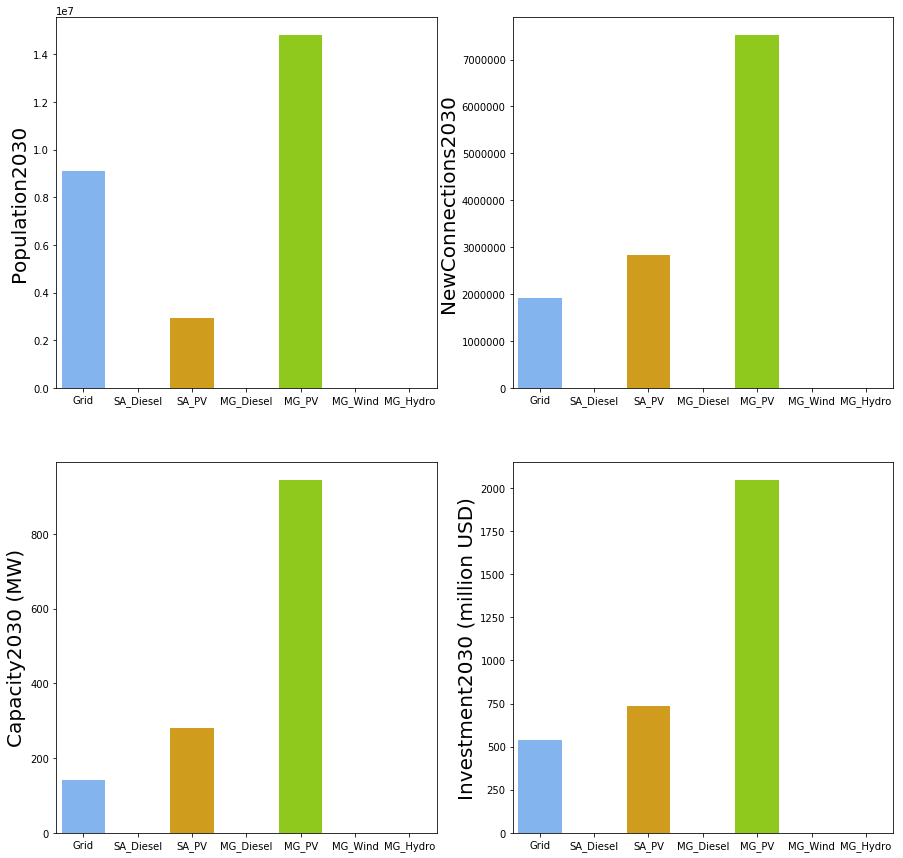

In [26]:
import matplotlib.pylab as plt
import seaborn as sns

colors = ['#73B2FF','#EDD100','#EDA800','#1F6600','#98E600','#70A800','#1FA800']
techs_colors = dict(zip(techs, colors))

summary_plot=summary_table.drop(labels='Total',axis=0)
fig_size = [15, 15]
font_size = 10
plt.rcParams["figure.figsize"] = fig_size
f, axarr = plt.subplots(2, 2)
fig_size = [15, 15]
font_size = 10
plt.rcParams["figure.figsize"] = fig_size

sns.barplot(x=summary_plot.index.tolist(), y=columns[4], data=summary_plot, ax=axarr[0, 0], palette=colors)
axarr[0, 0].set_ylabel(columns[4], fontsize=2*font_size)
axarr[0, 0].tick_params(labelsize=font_size)
sns.barplot(x=summary_plot.index.tolist(), y=columns[5], data=summary_plot, ax=axarr[0, 1], palette=colors)
axarr[0, 1].set_ylabel(columns[5], fontsize=2*font_size)
axarr[0, 1].tick_params(labelsize=font_size)
sns.barplot(x=summary_plot.index.tolist(), y=columns[6], data=summary_plot, ax=axarr[1, 0], palette=colors)
axarr[1, 0].set_ylabel(columns[6], fontsize=2*font_size)
axarr[1, 0].tick_params(labelsize=font_size)
sns.barplot(x=summary_plot.index.tolist(), y=columns[7], data=summary_plot, ax=axarr[1, 1], palette=colors)
axarr[1, 1].set_ylabel(columns[7], fontsize=2*font_size)
axarr[1, 1].tick_params(labelsize=font_size)

<Figure size 2160x2160 with 0 Axes>

2019-06-26 15:43:27,432		update_title_pos
2019-06-26 15:43:27,586		update_title_pos
2019-06-26 15:43:27,740		update_title_pos
2019-06-26 15:43:27,826		update_title_pos
2019-06-26 15:43:27,876		update_title_pos


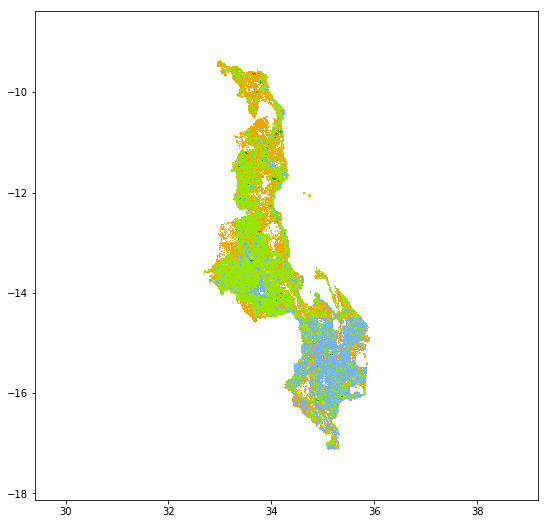

<Figure size 2160x2160 with 0 Axes>

In [27]:
from matplotlib import pyplot as plt
colors = ['#73B2FF','#EDD100','#EDA800','#1F6600','#98E600','#70A800','#1FA800']
plt.figure(figsize=(9,9))
plt.plot(onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==3, SET_X_DEG], onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==3, SET_Y_DEG], color='#EDA800', marker=',', linestyle='none')
plt.plot(onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==2, SET_X_DEG], onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==2, SET_Y_DEG], color='#EDD100', marker=',', linestyle='none')
plt.plot(onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==4, SET_X_DEG], onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==4, SET_Y_DEG], color='#1F6600', marker=',', linestyle='none')
plt.plot(onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==5, SET_X_DEG], onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==5, SET_Y_DEG], color='#98E600', marker=',', linestyle='none')
plt.plot(onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==6, SET_X_DEG], onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==6, SET_Y_DEG], color='#70A800', marker=',', linestyle='none')
plt.plot(onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==7, SET_X_DEG], onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==7, SET_Y_DEG], color='#1FA800', marker=',', linestyle='none')
plt.plot(onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==1, SET_X_DEG], onsseter.df.loc[onsseter.df['FinalElecCode{}'.format(end_year)]==1, SET_Y_DEG], color='#73B2FF', marker=',', linestyle='none')
if onsseter.df[SET_X_DEG].max() - onsseter.df[SET_X_DEG].min() > onsseter.df[SET_Y_DEG].max() - onsseter.df[SET_Y_DEG].min():
    plt.xlim(onsseter.df[SET_X_DEG].min() - 1, onsseter.df[SET_X_DEG].max() + 1)
    plt.ylim((onsseter.df[SET_Y_DEG].min()+onsseter.df[SET_Y_DEG].max())/2 - 0.5*abs(onsseter.df[SET_X_DEG].max() - onsseter.df[SET_X_DEG].min()) - 1, (onsseter.df[SET_Y_DEG].min()+onsseter.df[SET_Y_DEG].max())/2 + 0.5*abs(onsseter.df[SET_X_DEG].max() - onsseter.df[SET_X_DEG].min()) + 1)
else:
    plt.xlim((onsseter.df[SET_X_DEG].min()+onsseter.df[SET_X_DEG].max())/2 - 0.5*abs(onsseter.df[SET_Y_DEG].max() - onsseter.df[SET_Y_DEG].min()) - 1, (onsseter.df[SET_X_DEG].min()+onsseter.df[SET_X_DEG].max())/2 + 0.5*abs(onsseter.df[SET_Y_DEG].max() - onsseter.df[SET_Y_DEG].min()) + 1)
    plt.ylim(onsseter.df[SET_Y_DEG].min() -1, onsseter.df[SET_Y_DEG].max() +1)
plt.figure(figsize=(30,30))

## 9. Exporting results

This code generates three csv files:
 - one containing all the results for the scenario created
 - one containing the summary for the scenario created
 - one containing some if the key input variables of the scenario

Before we proceed, please write the scenario_name in the first cell below. then move on to the next cell and run it to browse to the directory where you want to save your results. Sample file shall be located at .\ gep-onsset\sample_output. 

**Note that if you do not change the scenario name, the previous output files will be overwritten

In [ ]:
scenario_name = "scenario_5"

In [ ]:
list1 = [('Start_year',start_year,'','',''), 
         ('End_year',end_year,'','',''),
         ('End year electrification rate target',electrification_rate_target,'','',''),
         ('Intermediate target year', intermediate_year,'','',''),
         ('Intermediate electrification rate target', intermediate_electrification_target,'','',''),
         ('PV cost adjustment factor', pv_adjustment_factor, '', '', ''),
         ('Urban target tier', urban_target_tier, '', '', ''),
         ('Rural target tier', rural_target_tier, '', '', ''),
         ('Prioritization', prioritization,'','','1 = baseline, 2 = intensification'),
         ('Auto intensification distance', auto_intensification, '', '', 'Buffer distance (km) for automatic intensification if choosing prioritization 1'),
         ('coordinate_units',coordinate_units,'','','1000 if coordinates are in m, 1 if coordinates are in km'),
         ('discount_rate',discount_rate,'','',''),
         ('pop_threshold',pop_threshold,'','',''),
         ('pop_start_year',pop_start_year,'','','the population in the base year (e.g. 2016)'),
         ('pop_end_year',end_year_pop,'','','the projected population in the end year (e.g. 2030)'),
         ('urban_ratio_start_year',urban_ratio_start_year,'','','the urban population population ratio in the base year (e.g. 2016)'),
         ('urban_ratio_end_year',urban_ratio_end_year,'','','the urban population population ratio in the end year (e.g. 2030)'),
         ('num_people_per_hh_urban',num_people_per_hh_urban,'','','the number of people per household expected in the end year (e.g. 2030)'),
         ('num_people_per_hh_rural',num_people_per_hh_rural,'','','the number of people per household expected in the end year (e.g. 2030)'),
         ('elec_ratio_start_year',elec_ratio_start_year,'','','the electrification rate in the base year (e.g. 2016)'),
         ('urban_elec_ratio',urban_elec_ratio,'','','urban electrification rate in the base year (e.g. 2016)'),
         ('rural_elec_ratio',rural_elec_ratio,'','','rural electrification rate in the base year (e.g. 2016)'),
         ('grid_generation_cost',grid_generation_cost,'','','This is the grid cost electricity USD/kWh as expected in the end year of the analysis'),
         ('grid_power_plants_capital_cost',grid_power_plants_capital_cost,'','','The cost in USD/kW to for capacity upgrades of the grid-connected power plants'),
         ('grid_losses',grid_losses,'','','The fraction of electricity lost in transmission and distribution (percentage)'),
         ('base_to_peak',base_to_peak,'','','The ratio of base grid demand to peak demand (percentage)'),
         ('existing_grid_cost_ratio',existing_grid_cost_ratio,'','','The additional cost per round of electrification (percentage)'),
         ('diesel_price',diesel_price,'','','This is the diesel price in USD/liter as expected in the end year of the analysis'),
         ('sa_diesel_capital_cost',sa_diesel_capital_cost,'','','Stand-alone Diesel capital cost (USD/kW) as expected in the years of the analysis'),
         ('mg_diesel_capital_cost',mg_diesel_capital_cost,'','','Mini-grid Diesel capital cost (USD/kW) as expected in the years of the analysis'),
         ('mg_pv_capital_cost',mg_pv_capital_cost,'','','Mini-grid PV capital cost (USD/kW) as expected in the years of the analysis'),
         ('mg_wind_capital_cost',mg_wind_capital_cost,'','','Mini-grid Wind capital cost (USD/kW) as expected in the years of the analysis'),
         ('mg_hydro_capital_cost',mg_hydro_capital_cost,'','','Mini-grid Hydro capital cost (USD/kW) as expected in the years of the analysis'),
         ('sa_pv_capital_cost_1',sa_pv_capital_cost_1,'','','Stand-alone PV capital cost (USD/kW) for household systems under 20 W'),
         ('sa_pv_capital_cost_2',sa_pv_capital_cost_2,'','','Stand-alone PV capital cost (USD/kW) for household systems between 21-50 W'),
         ('sa_pv_capital_cost_3',sa_pv_capital_cost_3,'','','Stand-alone PV capital cost (USD/kW) for household systems between 51-100 W'),
         ('sa_pv_capital_cost_4',sa_pv_capital_cost_4,'','','Stand-alone PV capital cost (USD/kW) for household systems between 101-200 W'),
         ('sa_pv_capital_cost_5',sa_pv_capital_cost_5,'','','Stand-alone PV capital cost (USD/kW) for household systems over 200 W'),
         ('mv_line_cost',mv_line_cost,'','','Cost of MV lines in USD/km'),
         ('lv_line_cost',lv_line_cost,'','','Cost of LV lines in USD/km'),
         ('mv_line_capacity',mv_line_capacity,'','','Capacity of MV lines in kW/line'),
         ('lv_line_capacity',lv_line_capacity,'','','Capacity of LV lines in kW/line'),
         ('lv_line_max_length',lv_line_max_length,'','','Maximum length of LV lines (km)'),
         ('hv_line_cost',hv_line_cost,'','','Cost of HV lines in USD/km'),
         ('mv_line_max_length',mv_line_max_length,'','','Maximum length of MV lines (km)'),
         ('hv_lv_transformer_cost',hv_lv_transformer_cost,'','','Cost of HV/MV transformer (USD/unit)'),
         ('mv_increase_rate',mv_increase_rate,'','','percentage'),
         ('max_grid_extension_dist',max_mv_line_dist,'','','Maximum distance that the grid may be extended by means of MV lines'),
         ('annual_new_grid_connections_limit', annual_new_grid_connections_limit,'','','This is the maximum amount of new households that can be connected to the grid in one year (thousands)'),
         ('grid_capacity_limit',annual_grid_cap_gen_limit,'','','This is the maximum generation capacity that can be added to the grid in one year (MW)'),
         ('GIS data: Administrative boundaries','','','','Delineates the boundaries of the analysis.'),
         ('GIS data: DEM','','','','Filled DEM (elevation) maps are use in a number of processes in the analysis (Energy potentials, restriction zones, grid extension suitability map etc.).'),
         ('GIS data: Hydropower','','','','Points showing potential mini/small hydropower potential.  Provides power availability in each identified point.'),
         ('GIS data: Land Cover','','','','Land cover maps are use in a number of processes in the analysis (Energy potentials, restriction zones, grid extension suitability map etc.).'),
         ('GIS data: Night-time Lights','','','','Dataset used to,identify and spatially calibrate the currently electrified/non-electrified population.'),
         ('GIS data: Population','','','','Spatial identification and quantification of the current (base year) population. This dataset sets the basis of the ONSSET analysis as it is directly connected with the electricity demand and the assignment of energy access goals'),
         ('GIS data: Roads','','','','Current road infrastructure is used in order to specify grid extension suitability.'),
         ('GIS data: Solar GHI','','','','Provide information about the Global Horizontal Irradiation (kWh/m2/year) over an area. This is later used to identify the availability/suitability of Photovoltaic systems.'),
         ('GIS data: Substations','','','','Current Substation infrastructure is used in order to specify grid extension suitability.'),
         ('GIS data: Existing grid','','','','Current grid network'),
         ('GIS data: Planned grid','','','','Planned/committed grid network extensions'),
         ('GIS data: Travel-time','','','','Visualizes spatially the travel time required to reach from any individual cell to the closest town with population more than 50,000 people.'),
         ('GIS data: Wind velocity','','','','Provide information about the wind velocity (m/sec) over an area. This is later used to identify the availability/suitability of wind power (using Capacity factors).'),
        ]
labels = ['Variable','Value', 'Source', 'Comments', 'Description']
df_variables = pd.DataFrame.from_records(list1, columns=labels)

In [ ]:
messagebox.showinfo('OnSSET', 'Browse to the folder where you want to save the outputs')

output_dir = filedialog.askdirectory()
output_dir_variables = os.path.join(output_dir, '{}_Variables.csv'.format(scenario_name))
output_dir_results = os.path.join(output_dir, '{}_Results.csv'.format(scenario_name))
output_dir_summaries = os.path.join(output_dir, '{}_Summaries.csv'.format(scenario_name))

In [ ]:
# Returning the result as a csv file
onsseter.df.to_csv(output_dir_results, index=False)

# Returning the summary as a csv file
summary_table.to_csv(output_dir_summaries, index=True)

# Returning the input variables as a csv file
df_variables.to_csv(output_dir_variables, index=False)